In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [34]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device: {device}')

#read in all the words
words = open('Dataset/Simple English/sh1.txt', 'r').read().splitlines()
words[:8]

Using device: cpu


['One dollar and eighty-seven cents. That was all. And sixty cents of it',
 'was in pennies. Pennies saved one and two at a time by bulldozing the',
 "grocer and the vegetable man and the butcher until one's cheeks burned",
 'with the silent imputation of parsimony that such close dealing',
 'implied. Three times Della counted it. One dollar and eighty-seven',
 'cents. And the next day would be Christmas.',
 '',
 'There was clearly nothing to do but flop down on the shabby little']

In [35]:
len(words)

222

In [36]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['¬'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)
vocab_size

{1: ' ', 2: '!', 3: '"', 4: '$', 5: "'", 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '7', 14: '8', 15: ':', 16: ';', 17: '?', 18: 'A', 19: 'B', 20: 'C', 21: 'D', 22: 'E', 23: 'F', 24: 'G', 25: 'H', 26: 'I', 27: 'J', 28: 'K', 29: 'M', 30: 'N', 31: 'O', 32: 'P', 33: 'Q', 34: 'R', 35: 'S', 36: 'T', 37: 'W', 38: 'Y', 39: '[', 40: ']', 41: 'a', 42: 'b', 43: 'c', 44: 'd', 45: 'e', 46: 'f', 47: 'g', 48: 'h', 49: 'i', 50: 'j', 51: 'k', 52: 'l', 53: 'm', 54: 'n', 55: 'o', 56: 'p', 57: 'q', 58: 'r', 59: 's', 60: 't', 61: 'u', 62: 'v', 63: 'w', 64: 'x', 65: 'y', 66: 'z', 0: '¬'}


67

In [37]:
# build the dataset
block_size = 3
def build_dataset(words):
     # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '¬':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([8902, 3]) torch.Size([8902])
torch.Size([1150, 3]) torch.Size([1150])
torch.Size([1193, 3]) torch.Size([1193])


In [38]:
# ------------ now made respectable :) -----------------

In [39]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([8902, 3]), torch.Size([8902]))

In [40]:
similarity_dimensions = 5
context_size = 3
hidden_neurons = 64

g = torch.Generator(device = device).manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, similarity_dimensions), generator=g, device = device)
W1 = torch.randn((similarity_dimensions * context_size, hidden_neurons), generator = g, device = device) * (5/3)/((similarity_dimensions * context_size)**0.5)
b1 = torch.randn(hidden_neurons, generator = g, device = device)
W2 = torch.randn((hidden_neurons, vocab_size), generator = g, device = device) * 0.01
b2 = torch.randn(vocab_size, generator = g, device = device) * 0

bngain = torch.ones((1, hidden_neurons))
bnbias = torch.zeros((1, hidden_neurons))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

5842


In [48]:
for p in parameters:
    print(p.nelement())

335
960
64
4288
67
64
64


In [47]:
start_time = time.time()
prev_time = time.time()
total_examples = 0
batch_size = 256
print_size = 1000
total_steps = 50000

for i in range(total_steps):        

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)).to(device)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    # forward pass
    emb = C[Xb].to(device) # embed the words into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.nn.ReLU(inplace=True)(hpreact).to(device) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    #print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.5 - (i  / (total_steps * 2))
    for p in parameters:
        p.data += -lr * p.grad


    if (i % print_size == 0):
        epoch_time = time.time() - start_time
        particular_time = epoch_time - prev_time
        prev_time = epoch_time
        examples = print_size * batch_size / particular_time
        total_examples += print_size * batch_size
        print(f"Steps: {i}, Lr: {lr:.3f}, time: {particular_time:.2f}, total time: {epoch_time:.2f} seconds, steps/s: {(print_size / particular_time):.2f}, examples/s: {examples:.2f}, total examples: {total_examples}, loss: {loss.item():.6f}")
    if (i % 5000 == 0):   
        dev_loss()
        training_loss()
#print(loss.item())

Steps: 0, Lr: 0.500, time: -1742510122.28, total time: 0.01 seconds, steps/s: -0.00, examples/s: -0.00, total examples: 256000, loss: 4.216601


NameError: name 'dev_loss' is not defined

In [119]:
def training_loss():
    emb = C[Xtr].to(device) # (32, 3, 2)
    h = torch.nn.ReLU(inplace=True)(emb.view(-1, similarity_dimensions * context_size) @ W1 + b1).to(device) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr)
    print(f"Train loss: {loss.item()}")

In [120]:
def dev_loss():

    emb = C[Xdev].to(device) # (32, 3, 2)
    h = torch.nn.ReLU(inplace=True)(emb.view(-1, similarity_dimensions * context_size) @ W1 + b1).to(device) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ydev)
    print(f"Dev loss: {loss.item()}")

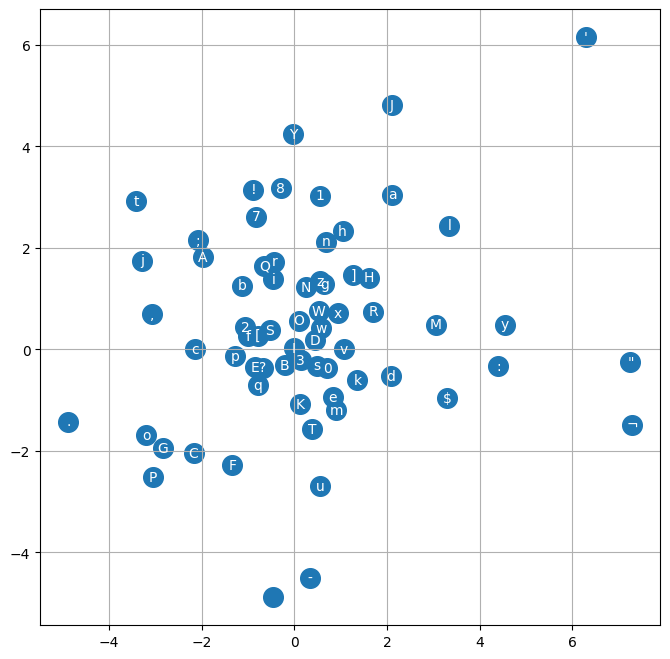

In [143]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [65]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [144]:
# sample from the model
block_size = 3
g = torch.Generator(device = device).manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])].to(device) # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1).to(device)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix != 0:
            out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

twatchin the come

at hers, of like han $8y youddexfood any counn wit it here is worty she siming and
a blyeesed hombs, Delerdid
stain, Jim

isescried up. It was inly bockla fine dolling falhite fame. And grewchain and gifs.
All
that and strice of broaddorny fixed fray to its here nex worw't wind
lsers, aonion you blyeeke in

Sud. Pression los had
meted as any and:Mber
Oh, and never, rivedy ariminy thanged the sy as plapresent buy and king
"Woched
that. Jeacile all ovest, and

"I
may, bys wigl ows he by you.



In [6]:
# Summary

In [25]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers = [
#  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
#]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

20637


In [26]:
# same optimization as last time
max_steps = 50000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

 #if i >= 1000:
 #  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  50000: 4.5443
   1000/  50000: 2.1719
   2000/  50000: 1.9753
   3000/  50000: 1.9998
   4000/  50000: 1.9401
   5000/  50000: 1.7597
   6000/  50000: 1.9848
   7000/  50000: 1.0726
   8000/  50000: 1.3070
   9000/  50000: 1.5067
  10000/  50000: 1.4048
  11000/  50000: 1.2278
  12000/  50000: 1.2701
  13000/  50000: 1.3380
  14000/  50000: 1.1067
  15000/  50000: 1.6149
  16000/  50000: 1.0710
  17000/  50000: 1.5524
  18000/  50000: 1.2649
  19000/  50000: 1.2690
  20000/  50000: 0.9601
  21000/  50000: 1.0164
  22000/  50000: 0.6012
  23000/  50000: 1.2032
  24000/  50000: 0.9230
  25000/  50000: 1.0532
  26000/  50000: 1.4486
  27000/  50000: 1.3704
  28000/  50000: 1.2402
  29000/  50000: 1.1916
  30000/  50000: 0.9737
  31000/  50000: 0.9491
  32000/  50000: 0.8684
  33000/  50000: 0.8942
  34000/  50000: 1.2971
  35000/  50000: 1.3578
  36000/  50000: 1.2040
  37000/  50000: 0.9773
  38000/  50000: 1.0436
  39000/  50000: 1.0861
  40000/  50000: 1.4877
  41000/  50000:

layer 1 (      Tanh): mean +0.01, std 0.92, saturated: 66.62%
layer 3 (      Tanh): mean +0.01, std 0.93, saturated: 67.31%


Text(0.5, 1.0, 'activation distribution')

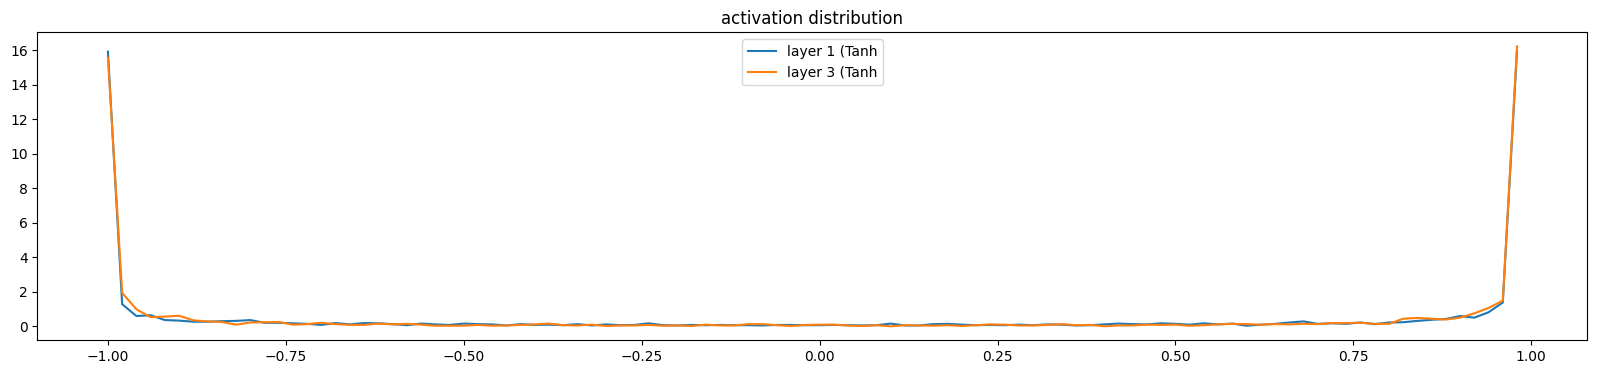

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000145, std 6.692252e-03
layer 3 (      Tanh): mean +0.000363, std 9.044330e-03


Text(0.5, 1.0, 'gradient distribution')

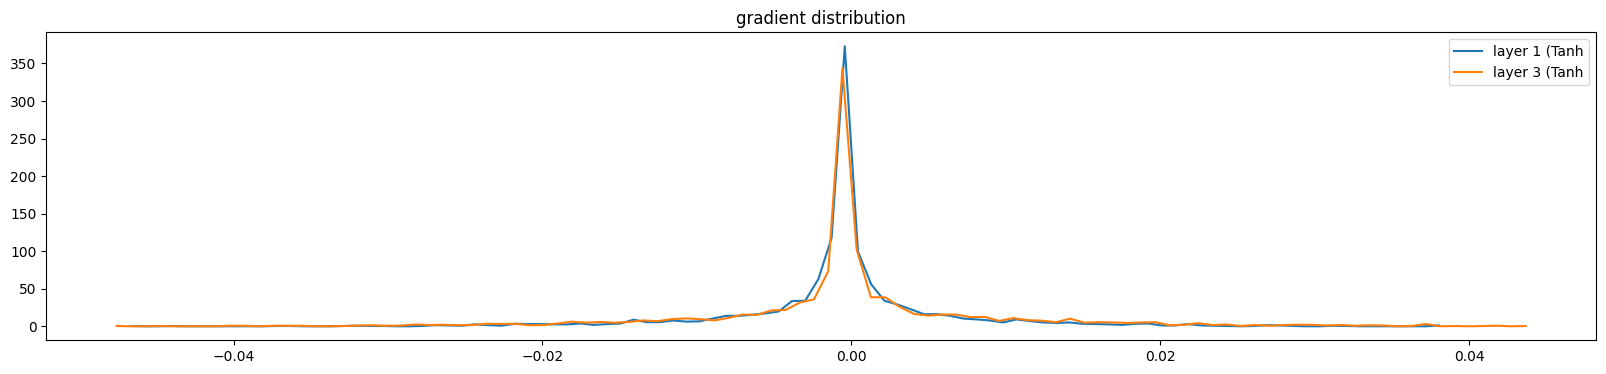

In [28]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (67, 10) | mean -0.000104 | std 1.554180e-02 | grad:data ratio 1.273422e-02
weight  (30, 100) | mean -0.000075 | std 1.414975e-02 | grad:data ratio 2.262782e-02
weight (100, 100) | mean +0.000134 | std 8.818638e-03 | grad:data ratio 2.229801e-02
weight  (100, 67) | mean +0.000000 | std 1.321659e-02 | grad:data ratio 3.649075e-02


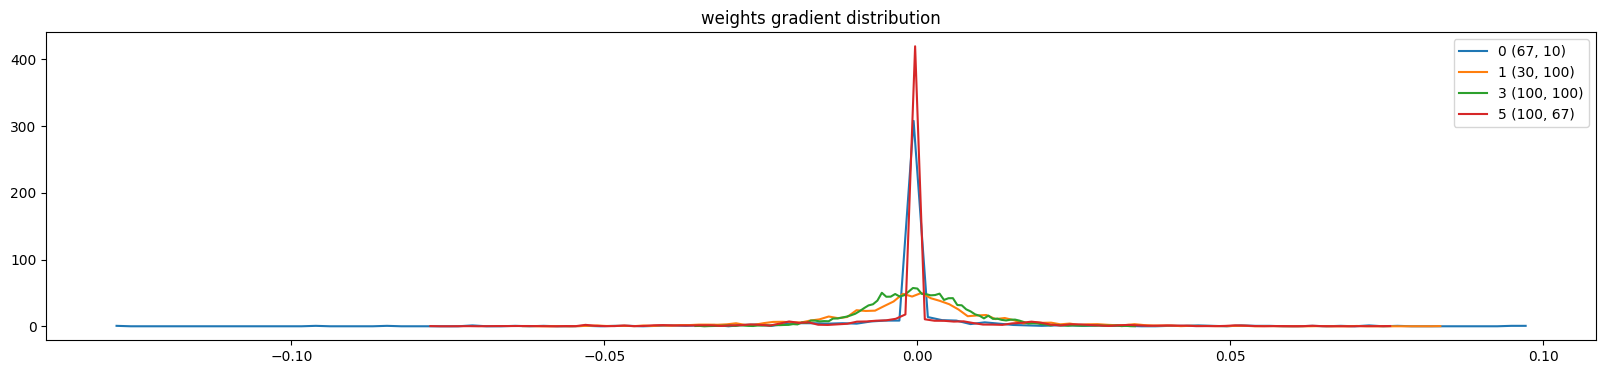

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

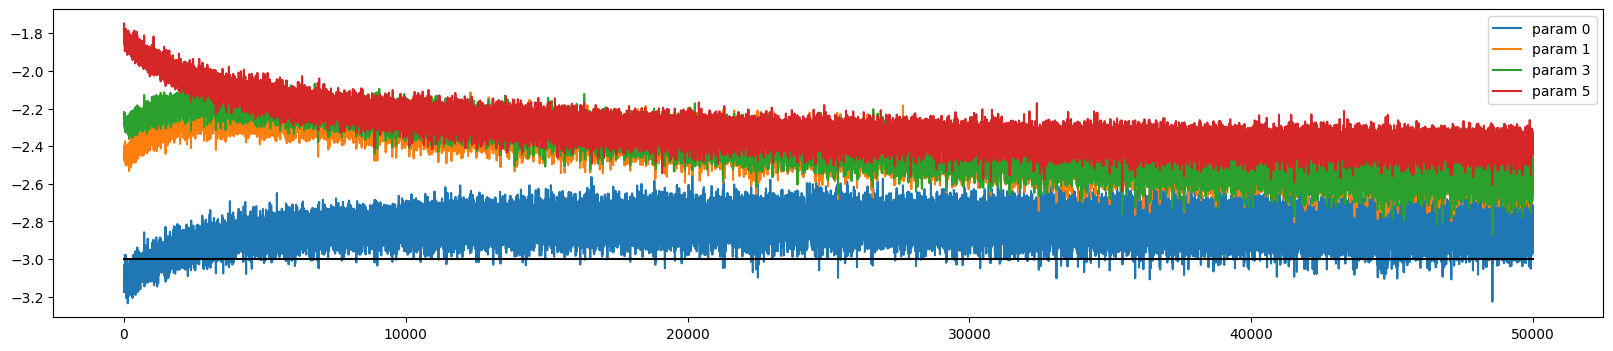

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.1031999588012695
val 2.859424591064453


In [32]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

twent in aftered for it of possestigatest. He eittle of a pression, beingham" in a plashe cove. As shabit of betwenty about magi.¬
table of think chile bast on afterly back, just it¬
fencerful,¬
that her fore and and een was soon flight a jrought doon the don't my had magi.¬
cent. It'll they to which¬
leatly.¬
Madame. "Take. Dell," saving even press burned eight anything.¬
turned and nice horrvat trication the "Mr. And the pures possed¬
went of the "Ding that a word her labovest below and shing a presenty mistmaste and the know and ke and and not word ove yet you--sold bright derfully acripped for and a procerful chand rims--a made by It my hairs of the fise of then, being curing to used of¬
Jim watch as alondsald base andow. as a months, "but of the shout to was, asked the present pennie, task, day ared it in her harden, sniffles, "Oh, and eight¬
Whilenderful could dolla oh whill the her stion he, Hair laboy. Young."¬
may, and at a hair. Twent it. James task, Hair," said he said home 